<a href="https://colab.research.google.com/github/ibarajas248/DataAnalisis_python/blob/main/Analisis_de_datos_mysql_pandas_matplotlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **EStoy usando https://console.clever-cloud.com/** para la base de datos mysql

In [ ]:
import requests
from bs4 import BeautifulSoup
import mysql.connector
#Índices de columnas en la tabla HTML donde se encuentran los datos que necesitas procesar.
YEARLY_CHANGE = 3
URBAN_POP = 10
WORLD_SHARE = 11
MAX_RETRIES = 3 #Número máximo de intentos para reintentar la solicitud HTTP en caso de error.


def clean_percentage(percentage):
    if percentage.endswith('%'):
        return float(percentage.replace('%', '').strip()) / 100
    return None

def process_row(celdas):
    row_data = []
    for i, td in enumerate(celdas):
        text = td.get_text(strip=True)
        if i in (YEARLY_CHANGE, URBAN_POP, WORLD_SHARE):

            if text == "N.A." or text == "":
                text = None
            else:
                text = clean_percentage(text)
        elif i != 1:
            if text == "N.A." or text == "":
                text = None
            else:
                text = text.replace(',', '').strip()
                try:
                    text = float(text)
                except ValueError:
                    pass
        row_data.append(text)
    return row_data

def process_url(url, cursor, sql_insert, db):
    for _ in range(MAX_RETRIES):
        try:
            response = requests.get(url)
            if response.status_code != 200:
                print(f'Error al acceder a {url}: Código de estado {response.status_code}')
                continue

            soup = BeautifulSoup(response.text, 'html.parser')
            tabla = soup.find('table')

            if tabla:
                #ITERO POR LAS FILAS
                for fila in tabla.find_all('tr')[1:]:  # Omitir el encabezado
                    celdas = fila.find_all('td') #CELDAS DE CADA FILA
                    if celdas and len(celdas) == 12: #NUMERO DE COLUMNAS
                        row_data = process_row(celdas)
                        if len(row_data) == 12:
                            cursor.execute(sql_insert, row_data)
                        else:
                            print("Número incorrecto de elementos en row_data:", row_data)
                db.commit()
                print(f'Datos de la tabla exportados correctamente a la base de datos MySQL')
            else:
                print("No se encontró tabla válida en la página.")
            break
        except requests.RequestException as e:
            print(f'Error de solicitud para {url}: {str(e)}')
        except Exception as e:
            print(f'Error al procesar datos de {url}: {str(e)}')



def main():
    db_config = {
        "host": "bcbey3gcqkkaqp4a7jm6-mysql.services.clever-cloud.com",
        "user": "uhv0hvx1jyevllcy",
        "password": "njR6W5pm7Af6y3I9fbT0",
        "database": "bcbey3gcqkkaqp4a7jm6"
    }

    sql_create_table = """
    CREATE TABLE IF NOT EXISTS population_2 (
        ranq VARCHAR(255),
        country VARCHAR(255),
        population VARCHAR(255),
        yearlychange VARCHAR(255),
        netchange VARCHAR(255),
        density VARCHAR(255),
        landarea VARCHAR(255),
        migrants VARCHAR(255),
        fertrate VARCHAR(255),
        medaage VARCHAR(255),
        urbanpop VARCHAR(255),
        worldshare VARCHAR(255)
    )
    """

    sql_insert = """
    INSERT INTO population_2 (ranq, country, population, yearlychange, netchange, density, landarea, migrants, fertrate, medaage, urbanpop, worldshare)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """

    urls = ['https://www.worldometers.info/world-population/population-by-country/']

    try:
        db = mysql.connector.connect(**db_config)
        cursor = db.cursor()

        # Crear la tabla si no existe
        cursor.execute(sql_create_table)
        db.commit()
        print("Tabla 'population' creada correctamente o ya existente.")

        # Eliminar registros existentes antes de comenzar
        delete_query = "DELETE FROM population"
        cursor.execute(delete_query)
        db.commit()
        print("Registros existentes eliminados correctamente.")

        # Procesar cada URL para insertar datos
        for url in urls:
            process_url(url, cursor, sql_insert, db)

    except mysql.connector.Error as e:
        print(f'Error de MySQL: {str(e)}')

    finally:
        cursor.close()
        db.close()

if __name__ == "__main__":
    main()


if __name__ == "__main__":
    main()

Tabla 'population' creada correctamente o ya existente.
Registros existentes eliminados correctamente.
Datos de la tabla exportados correctamente a la base de datos MySQL
Tabla 'population' creada correctamente o ya existente.
Registros existentes eliminados correctamente.
Datos de la tabla exportados correctamente a la base de datos MySQL


In [3]:
pip install matplotlib seaborn

# Nueva sección

In [4]:
pip install mysql.connector

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mysql.connector


In [6]:



def connect_to_database():
    return mysql.connector.connect(
        host="bcbey3gcqkkaqp4a7jm6-mysql.services.clever-cloud.com",
        database="bcbey3gcqkkaqp4a7jm6",
        user="uhv0hvx1jyevllcy",
        password="njR6W5pm7Af6y3I9fbT0"
    )



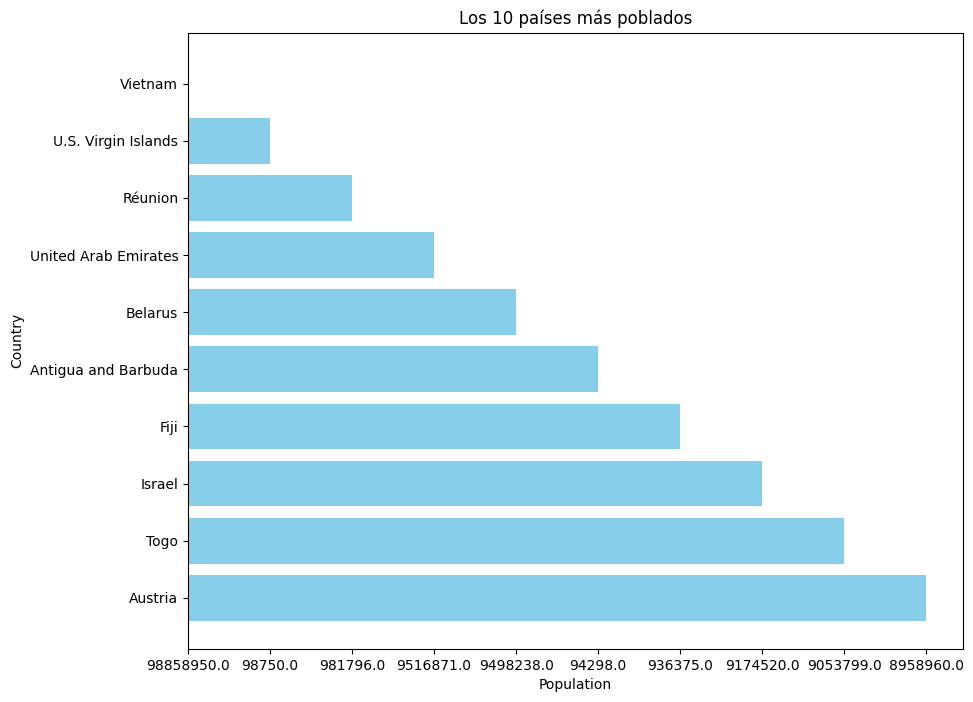

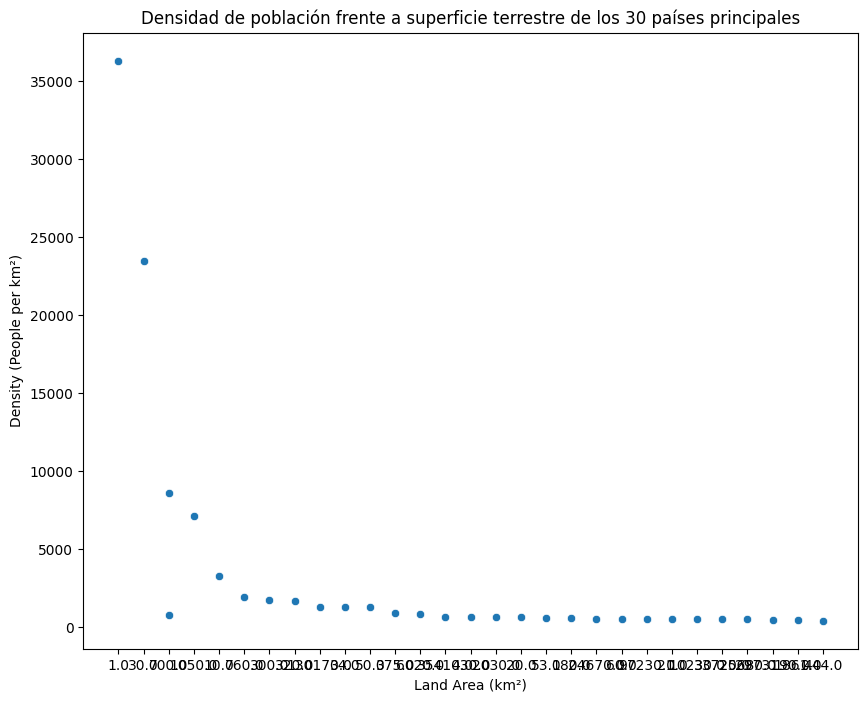

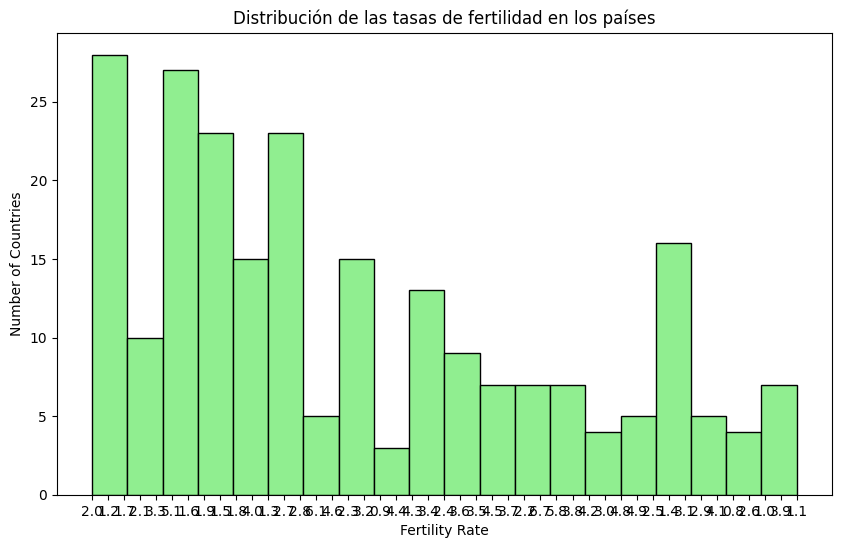

In [8]:
def run_query(query):
    db = connect_to_database()  # Conecta a la base de datos
    cursor = db.cursor()        # Crea un cursor para ejecutar comandos SQL
    cursor.execute(query)       # Ejecuta la consulta SQL proporcionada
    result = cursor.fetchall()  # Recupera todos los resultados de la consulta
    cursor.close()              # Cierra el cursor
    db.close()                  # Cierra la conexión a la base de datos
    return pd.DataFrame(result) # Convierte los resultados en un DataFrame de Pandas
    print(db)

query1 = """
SELECT Country, Population
FROM population_2
ORDER BY Population DESC
LIMIT 10;
"""


# Ejecutar una consulta SQL y obtener los resultados en un DataFrame
df1 = run_query(query1)
# Crear una nueva figura de matplotlib con tamaño personalizado
plt.figure(figsize=(10, 8))
# Crear un gráfico de barras horizontales
plt.barh(df1[0], df1[1], color='skyblue')
# Agregar etiquetas y título al gráfico
plt.xlabel('Population')  # Etiqueta del eje x (población)
plt.ylabel('Country')     # Etiqueta del eje y (país)
plt.title('Los 10 países más poblados')  # Título del gráfico

# Invertir el eje y para ordenar de mayor a menor población
plt.gca().invert_yaxis()

# Mostrar el gráfico
plt.show()


query2 = """
SELECT Country, Population / LandArea AS Density, LandArea
FROM population_2
WHERE LandArea > 0
ORDER BY (Population / LandArea) DESC
LIMIT 30;
"""
df2 = run_query(query2)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df2[2], y=df2[1])
plt.xlabel('Land Area (km²)')
plt.ylabel('Density (People per km²)')
plt.title('Densidad de población frente a superficie terrestre de los 30 países principales')
plt.show()


def run_query(query):
    db = connect_to_database()
    cursor = db.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    cursor.close()
    db.close()
    return pd.DataFrame(result, columns=['Fertility Rate'])

query = """
SELECT FertRate FROM population_2 WHERE FertRate IS NOT NULL;
"""
df = run_query(query)

# Histograma de Tasas de Fertilidad
plt.figure(figsize=(10, 6))
plt.hist(df['Fertility Rate'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Fertility Rate')
plt.ylabel('Number of Countries')
plt.title('Distribución de las tasas de fertilidad en los países')
plt.show()

In [ ]:


def run_query(query):
    db = connect_to_database()  # Conecta a la base de datos
    cursor = db.cursor()        # Crea un cursor para ejecutar comandos SQL
    print("Executing query:")
    print(query)                # Imprime la consulta SQL
    cursor.execute(query)       # Ejecuta la consulta SQL proporcionada
    result = cursor.fetchall()  # Recupera todos los resultados de la consulta
    cursor.close()              # Cierra el cursor
    db.close()                  # Cierra la conexión a la base de datos
    return pd.DataFrame(result) # Convierte los resultados en un DataFrame de Pandas

query = """
SELECT FertRate FROM population WHERE FertRate IS NOT NULL;
"""
df = run_query(query)

# Imprimir el DataFrame para verificar los resultados
#print(df.head(20))


In [ ]:
print("prueba")